# Study recording

author: steeve.laquitaine@epf.ch

purpose: check synchrony between unit spikes and traces in 40 min silico Marques recording (validated).

### Setup 

activate spikeinterf0_100_5

In [3]:
# listen to changes
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np 
import spikeinterface as si

# set project path
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.load import load_campaign_params

# SETUP PARAMETERS

# silico
data_conf, param_conf_sili = get_config(
    "silico_neuropixels", "concatenated"
).values()
PREPRO_PATH = data_conf["preprocessing"]["output"]["trace_file_path"]
SORTING_TRUE_PATH = data_conf['sorting']['simulation']['ground_truth']['output']

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIGSIZE = (15,10)#(6, 25)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e10]
savefig_cfg = {"transparent":True}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

2024-05-01 13:04:04,914 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-01 13:04:04,936 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Locate units near 1st column's site 48 (middle site)

3517481 is the closest. Look at its spikes.

#### Get 1st col's sites 

In [ ]:
# get preprocessed
Recording = si.load_extractor(PREPRO_PATH)

# get layers
layers = Recording.get_property("layers")

# get 1st column sites by layer
col1_site_out = np.where(layers[:96] == "Outside")[0]
col1_site_l1 = np.where(layers[:96] == "L1")[0]
col1_site_l2_3 = np.where((layers[:96] == "L2") | (layers[:96] == "L3"))[0]
col1_site_l4 = np.where(layers[:96] == "L4")[0]
col1_site_l5 = np.where(layers[:96] == "L5")[0]
col1_site_l6 = np.where(layers[:96] == "L6")[0]

#### Find highest FR nearby units

3517481    18.587247
3887809    19.249922
3670248    19.877709
4189686    23.015581
3783354    24.194565
dtype: float64

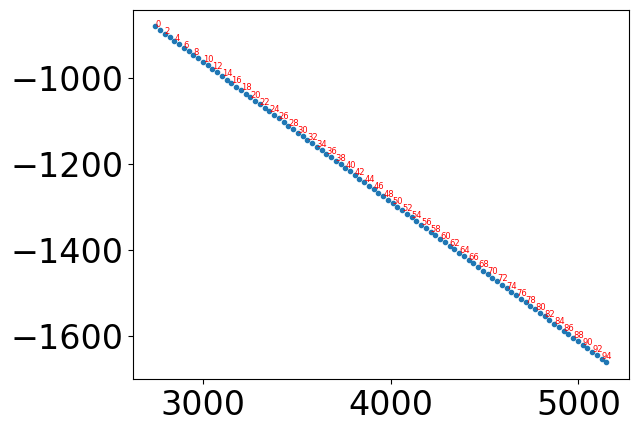

In [5]:
# ***** get 1st column-site coordinates *******
site_coords = Recording.get_property("location")[:96]
channel_ids = Recording.channel_ids
plt.plot(site_coords[:, 0], site_coords[:, 1], ".")

# label sites
for ix in range(len(site_coords)):
    if ix % 2 == 0:
        plt.text(
            site_coords[ix, 0],
            site_coords[ix, 1],
            "%s" % (str(channel_ids[ix])),
            size=6,
            zorder=100,
            color="r",
        )

# ******** locate units near site 48 **********

from src.nodes.utils import euclidean_distance

# find nearby true units
SortingTrue = si.load_extractor(SORTING_TRUE_PATH)
SortingTrue.unit_ids

# (1m) load true unit coordinates
params = load_campaign_params(data_conf)

unit_coords = params["circuit"].cells.get(
    group=SortingTrue.unit_ids.tolist(),
    properties=[
        "x",
        "y",
        "z",
    ],
)

# find the units near the 96 sites of the first column

# site 48 (middle of the col)
s_i = 48

# get nearest units
e_dist = []
for u_i in range(len(unit_coords.values)):
    e_dist.append(euclidean_distance(unit_coords.values[u_i], site_coords[s_i]))
series = pd.Series(e_dist)
series.index = SortingTrue.unit_ids
nearest_units = series.sort_values()
nearest_units.iloc[:5]

### Plot the unit spikes with site 48's traces

In [6]:
# nearby units with highest FR
# 4216128
# 4111550
# 3993908
# 3887809
unit_spike_ttp = SortingTrue.get_unit_spike_train(unit_id=3866607)
print(
    "Firing rate:",
    len(SortingTrue.get_unit_spike_train(unit_id=3866607))
    / Recording.get_total_duration(),
    "Hz",
)

Firing rate: 0.721574712173687 Hz


In [32]:
# choose a period (start from 1)
# - 1st 0-10 min block (NUM=1)
# - 2nd 10-20 min block (NUM=3100)
# - 3nd 20-30 min block (NUM=6100)
# - 4rd 30-40 min block (NUM=9100)
NUM = 9100

period start (min): 30.33  - end (min): 30.333332916666667


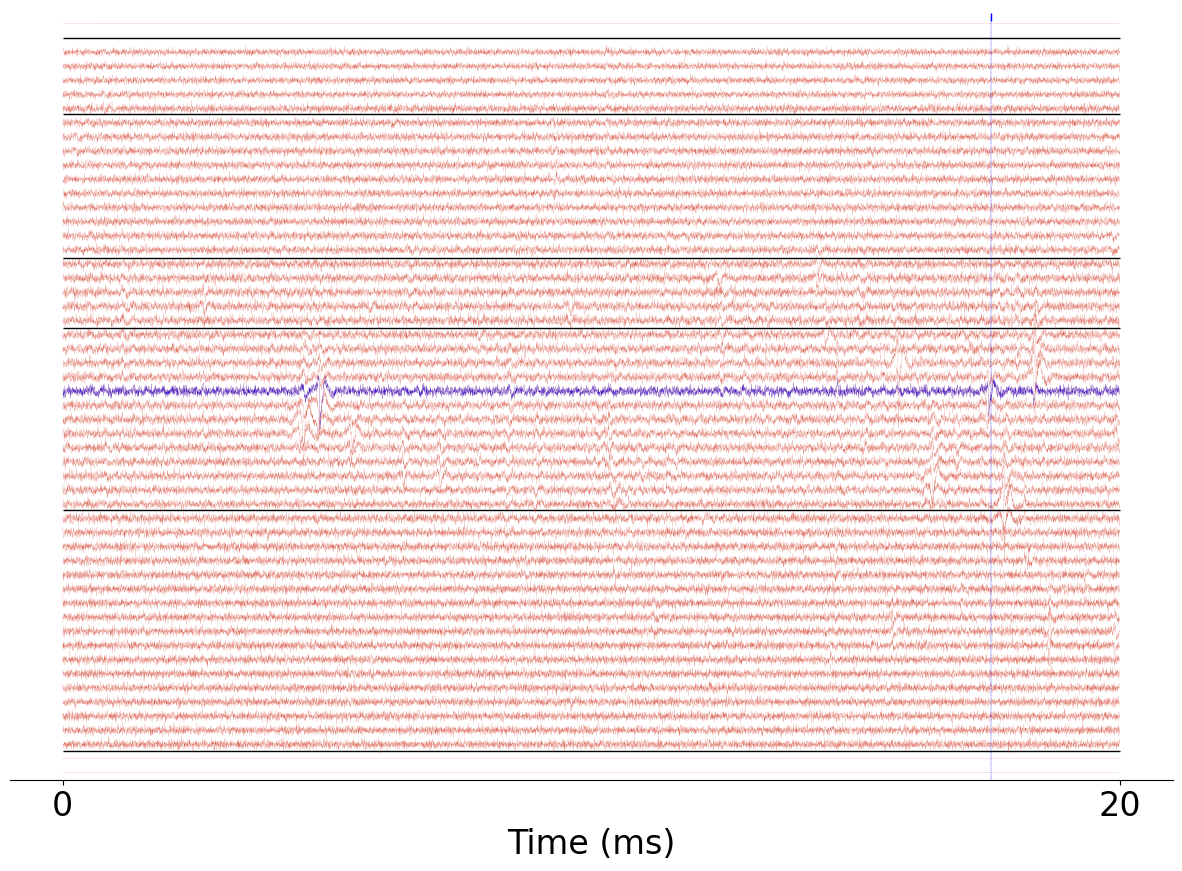

In [33]:
# takes 5 secs

# parametrize

SAMPFREQ = 40000  # hz
LINEWIDTH = 0.1
PLOT_Y_PITCH = 20
DURATION = 200  # 20  # in ms, 46
n_timepoints = int(DURATION * SAMPFREQ / 1000)
PERIOD = np.arange((NUM - 1) * n_timepoints, NUM * n_timepoints, 1)
Y_MAX = PLOT_Y_PITCH * 95

# plot
prep_traces = Recording.get_traces()
n_contacts = prep_traces.shape[1]

# spike trains
# unit1
unit_spike_ttp_1 = SortingTrue.get_unit_spike_train(unit_id=3887809)
spike_loc_in_period_1 = np.intersect1d(unit_spike_ttp_1, PERIOD, return_indices=True)[2]

# unit 2
unit_spike_ttp_2 = SortingTrue.get_unit_spike_train(unit_id=3517481)
spike_loc_in_period_2 = np.intersect1d(unit_spike_ttp_2, PERIOD, return_indices=True)[2]

# unit 3
unit_spike_ttp_3 = SortingTrue.get_unit_spike_train(unit_id=4216128)
spike_loc_in_period_3 = np.intersect1d(unit_spike_ttp_3, PERIOD, return_indices=True)[2]

# unit 4
unit_spike_ttp_4 = SortingTrue.get_unit_spike_train(unit_id=4111550)
spike_loc_in_period_4 = np.intersect1d(unit_spike_ttp_4, PERIOD, return_indices=True)[2]

# plot 384 contacts x 5 ms (like Trautmann et al 2023)

# plot (0: bottom 96:top)
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
pos_up = 0
row = 0
for contact_i in np.arange(0, 96, 1):
    # mark the first trace of each layer
    # layer 6
    if contact_i == col1_site_l6[0]:
        ax.hlines(
            y=0.98 * pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=1
        )

    # layer 5
    if contact_i == col1_site_l5[0]:
        ax.hlines(
            y=0.99 * pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=1
        )

    # layer 4
    if contact_i == col1_site_l4[0]:
        ax.hlines(
            y=0.99 * pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=1
        )

    # layer 2
    if contact_i == col1_site_l2_3[0]:
        ax.hlines(
            y=0.99 * pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=1
        )

    # layer 1
    if contact_i == col1_site_l1[0]:
        ax.hlines(
            y=0.98 * pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=1
        )

    # Outside
    if contact_i == 73:
        ax.hlines(y=pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=1)

    # all other traces
    else:
        ax.plot(
            prep_traces[PERIOD, contact_i] + pos_up,
            linewidth=LINEWIDTH,
            color=COLOR_SILI,
        )

    # mark target site for spikes ttp
    if contact_i == 48:
        ax.plot(
            prep_traces[PERIOD, contact_i] + pos_up,
            linewidth=LINEWIDTH,
            color="b",
        )
    pos_up += PLOT_Y_PITCH

# mark spike timestamp for site 48
# unit 1
plt.plot(
    spike_loc_in_period_1, np.repeat(Y_MAX - 410, len(spike_loc_in_period_1)), "b|"
)
plt.vlines(
    spike_loc_in_period_1, 410, Y_MAX - 410, color="b", linestyle="--", linewidth=0.3
)

# unit 2
plt.plot(
    spike_loc_in_period_2, np.repeat(Y_MAX - 410, len(spike_loc_in_period_2)), "g|"
)
plt.vlines(
    spike_loc_in_period_2, 410, Y_MAX - 410, color="g", linestyle="--", linewidth=0.3
)

# unit 3
plt.plot(
    spike_loc_in_period_3,
    np.repeat(Y_MAX - 410, len(spike_loc_in_period_3)),
    color="orange",
    marker="|",
)
plt.vlines(
    spike_loc_in_period_3,
    410,
    Y_MAX - 410,
    color="orange",
    linestyle="--",
    linewidth=0.3,
)

# unit 3
plt.plot(
    spike_loc_in_period_4,
    np.repeat(Y_MAX - 410, len(spike_loc_in_period_4)),
    color="r",
    marker="|",
)
plt.vlines(
    spike_loc_in_period_4, 410, Y_MAX - 410, color="r", linestyle="--", linewidth=0.3
)

# legend
ax.spines[["left", "right", "top"]].set_visible(False)
ax.set_xticks([0, n_timepoints])
ax.set_xticklabels([0, 20])
ax.set_xlabel("Time (ms)")
ax.set_ylim([410, Y_MAX - 400])
plt.yticks([])

print(
    "period start (min):",
    PERIOD[0] / 40000 / 60,
    " - end (min):",
    PERIOD[-1] / 40000 / 60,
)